<a href="https://colab.research.google.com/github/ptkeens/cs5262-data-science-project/blob/eda/neo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating the Danger of Near Earth Orbit Asteroids

## Background
Asteroids are the rocky remnants of material leftover from the solar system's formation, and are generally found in our solar system's "main belt", located between Mars and Jupitter. <sub>1</sub>. The current known asteroid count is 1,302,459, the vast majority of which orbit in the main asteroid belt. <sub>1</sub>. Asteroids are generally classified into 3 categories: Main Belt, Trojan, and Near-Earth <sub>1</sub>.

## Project Description
This project will focus on Near-Earth Objects (NEO). These objects are defined as "potentially hazardous" when its minimum orbit intersection distance is &lt;0.05 AU (4,647,790 mi) and it has an absolute magnitude of H&lt;22 (i.e. mean diameter > 140 m)<sub>2</sub>. Given that we are evaluating space-bound objects, it is important to remember that many of these values are given in a range format, or are an estimation based on available data sources. The data has been gathered in a kaggle dataset, which was sourced from the NASA NEO Earth Close Approaches API (https://cneos.jpl.nasa.gov/ca/).

## Performance Metrics
In this project, we have a set of 27,423 unique NEO objects with accompanying attribute data such as estimated diameter, relative velocity (to Earth at close approach), the distance by which it misses the Earth, its absolute magnitude, and whether or not it is considered "hazardous".

The goal of this project will be to clean the data to ensure it obeys the defined rules for an object being considered hazardous, and to then use this data as a training set for a machine-learning model to evaluate the boolean condition of if an NEO is considered hazardous. The exact mathematical expressions that will be used will be discovered as we progress through the course.

## Data Sources
This project is using data from a kaggle dataset, found [here](https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects). The data was pulled using [this script](https://gist.github.com/sameepv21/79d85bf0ae1830136b292bb9e3eec784)

1 Nasa (2021, July 19). *Asteroids*. https://solarsystem.nasa.gov/asteroids-comets-and-meteors/asteroids/in-depth/

2 Perna, D., Barucci, M.A, Fulchignoni, M (2013). "The near-Earth objects and their potential threat to our planet". *The Astronomy and astrophysics review*, 21(1), 1-28

## Setup and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

In [4]:
raw = pd.read_csv('neo_v2.csv')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


## Examine the properties of the data that has been loaded

In [5]:
# Get some statistical data points from the frame
raw.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


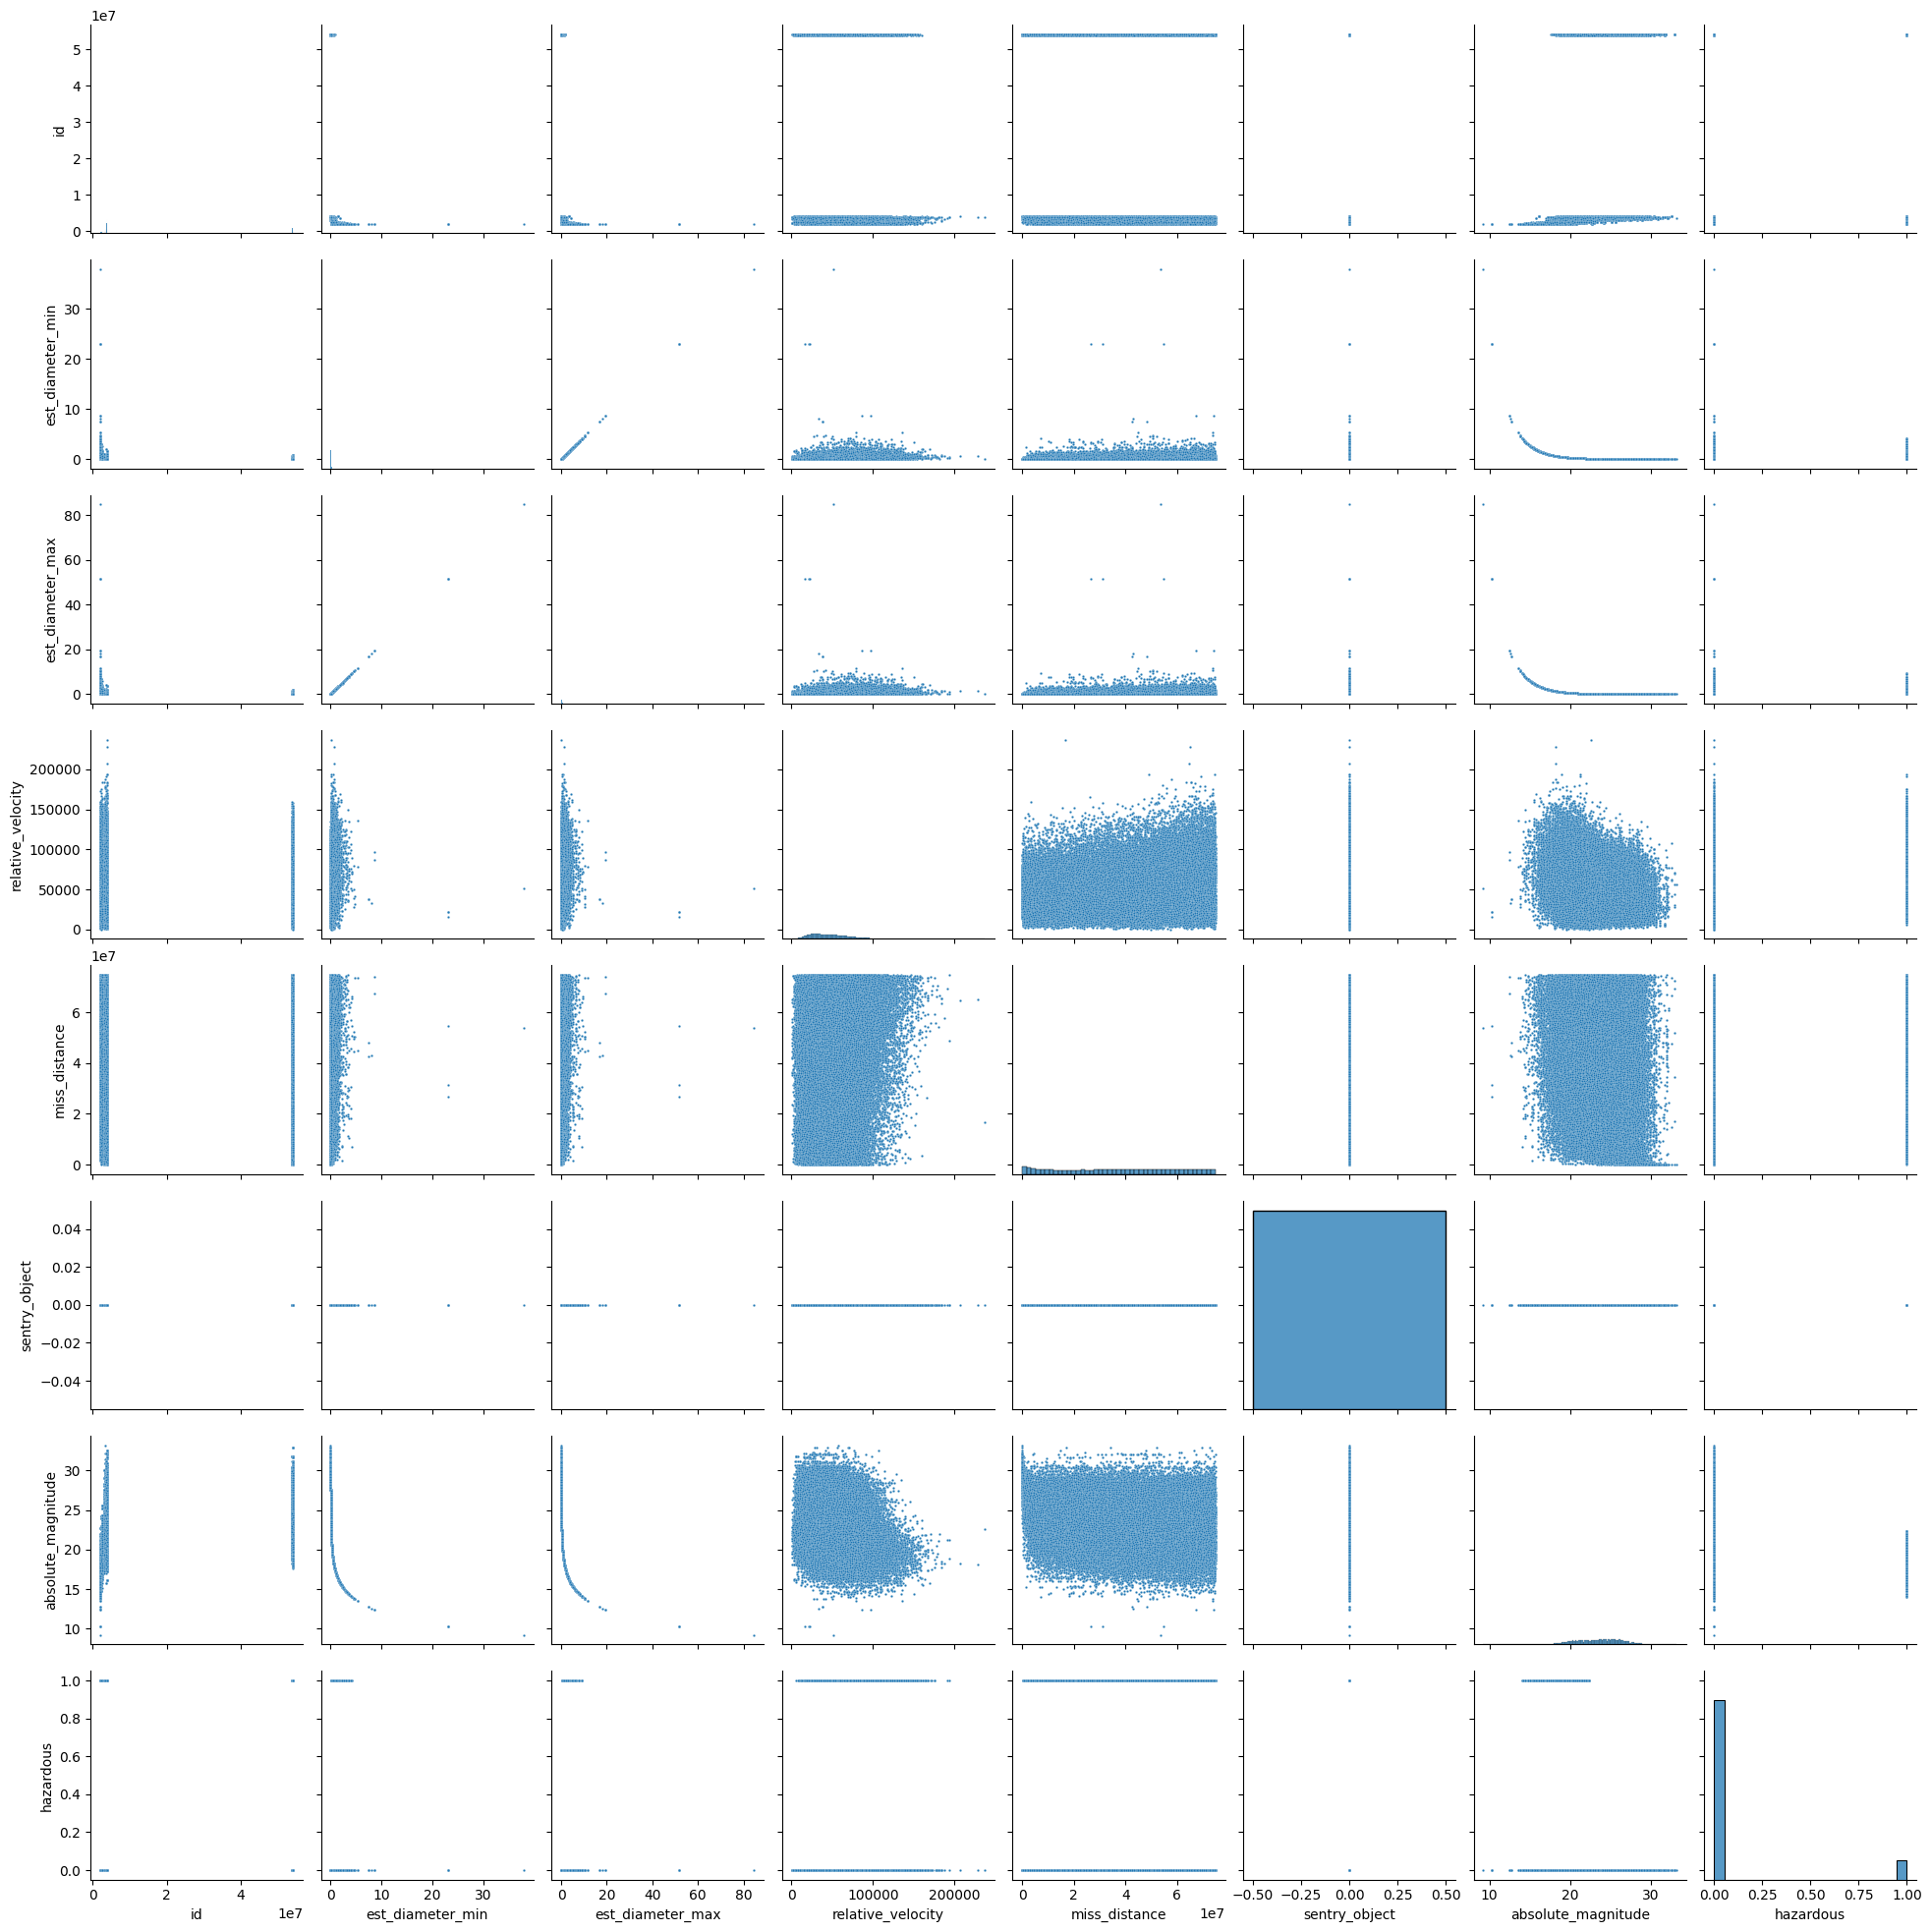

In [7]:
# Construct a pairplot for more detailed correlative analysis
sns.pairplot(raw, plot_kws={'s': 3})

## Exploratory Data Analysis

I have a few primary questions I would like to answer by examining the data more closely:

1.   **How balanced is this data set?** Considering this contains 90,836 NEO events, I imagine that a large percentage of the events are in fact, non-hazardous based on the algorithm described in the project description above. If this is the case, how will we solve this so that our ML model doesn't just predict events as non-hazardous so it performs well?
2.   **What is the correlation between size and magnitude?** We can observe what looks to be a relationship between these values by looking at the pairplot above. What is the nature of this relationship?
3.   **Do we have any data that needs to be dropped?** Can any data that is in the set contribute to leakage? What about outliers?


### 1. Data Set Balance
Lets examine how balanced this dataset is and come to some conclusions

#### Data Exploration

False    81996
True      8840
Name: hazardous, dtype: int64


([<matplotlib.patches.Wedge at 0x796de60f5300>,
 [Text(-1.0489888280748159, 0.33109279450665313, 'False'),
  Text(1.0489888435743868, -0.3310927453999418, 'True')])

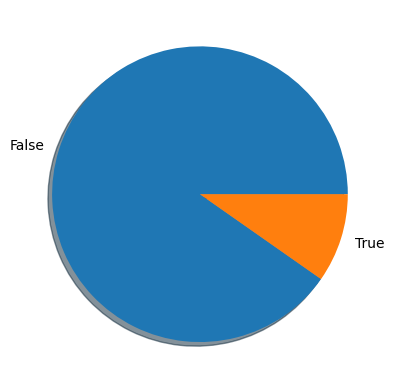

In [9]:
# 1. Data Set Balance
hazardous_values = raw['hazardous'].value_counts()
print(hazardous_values)
plt.pie(hazardous_values, labels=hazardous_values.index, shadow = True)


#### Analysis
There are `81,996` instances that have been categorized as non-hazardous, and only `8,840` events that are considered hazardous. This means that only **9%** of our data represents our target fetaure that we want to predict. Given what we know about ML models, the "safe bet" for the model is just to predict non-hazardous regardless of what the data says, because that would be the correct prediction 81% of the time for this data.

#### Tasks
1. I will need to undersample the majority class (non-hazardous) so that I can have a more representative class balance. Ideally I would want to have a near equal split. Considering I have 8,840 hazardous events, I could leverage `scikit-learn` to [resample](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) the data into a majority and minority class set with a maximum class size of 8,840 for each. This will remove the heavy bias and remove the "easy out" for the model.
2. After rebalancing the data set, I need to re-evaluate the data via a new session of EDA to see if/how relationships have changed

### 2. Correlation: Size and Magnitude
Let's examine the correlation between size and magnitude a little closer and come up with an explanation for why we see this.

#### Data Exploration

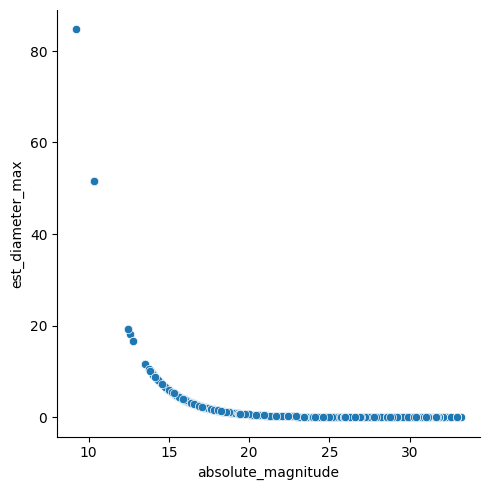

In [12]:
# Plot the relationship between absolute magnitude (x) and the estimated maximum diameter (y)
sns.relplot(raw, x="absolute_magnitude", y="est_diameter_max")

In [18]:
# Create a correlation coefficient between the two features we are interested in
coefficient = pd.DataFrame({
    "diameter": raw["est_diameter_max"],
    "magnitude": raw["absolute_magnitude"],
}).corr()

# Print this out
print(coefficient)

           diameter  magnitude
diameter   1.000000  -0.560188
magnitude -0.560188   1.000000


#### Analysis
So as absolute magnitude increases, I am seeing a decrease in the maximum diameter (estimated). I can observe the same relationship with the minimum estimated diameter, so I chose to do this correlative analysis on the maximum version of the tuple.

The pearson correlation is `-0.56`, which is around the commonly accepted bounds of `0.5` to `1.0`, indicating a strong correlation indicating that as one feature increases, the other decreases.

So the features are correlated, but why? The estimated diameter is rather self-evident, but what does absolute magnitude represent? We know that absolute magnitude represents the intrinsic [luminosity](https://www.phys.ksu.edu/personal/wysin/astro/magnitudes.html) of an object (how bright it is from a distance of 10 parsecs from the earth). We also know, due to the inverse square law for light, that the intensity of light diminishes proportionally to the square of the distance between the source and the observer. The absolute magnitude scale indeed reflects this relationship but in the inverse direction: Larger magnitude values represent fainter objects.

Taking this into consideration, this relationship **makes sense**, and would be expected. This also explains why the determination for an object being hazardous relies of the H <= 22. When I first saw this formula, I was very confused about why we would want a *smaller* value!


#### Tasks
I do not feel that there are any tasks to be done for this observation, but in keeping with the format of this notebook, I have a task section for this data observation.

### 3. Data Pruning


#### Data Exploration

Sentry object values: 
False    90836
Name: sentry_object, dtype: int64

Unique ID values: 
27423

List of orbiting bodies
Earth    90836
Name: orbiting_body, dtype: int64


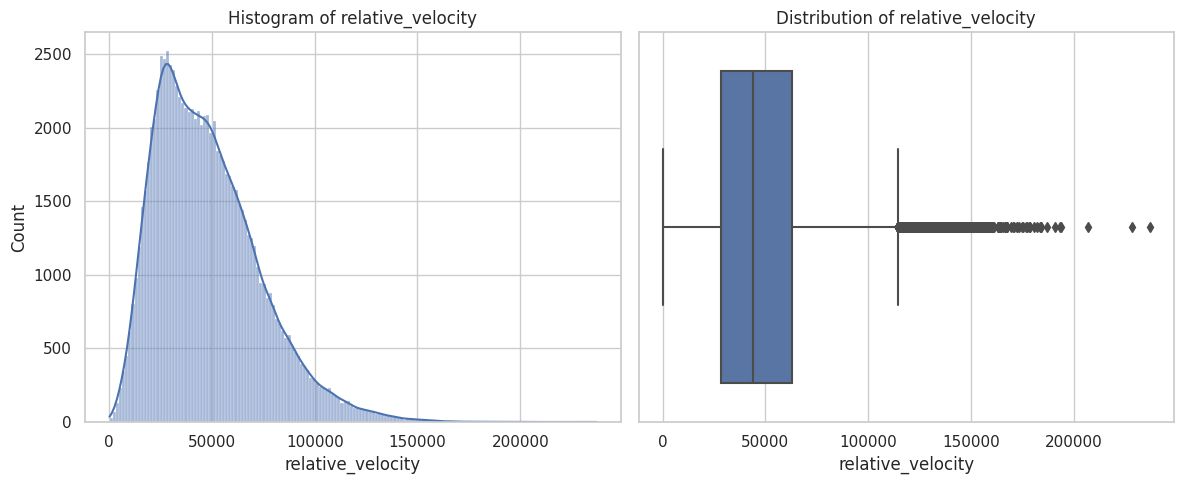

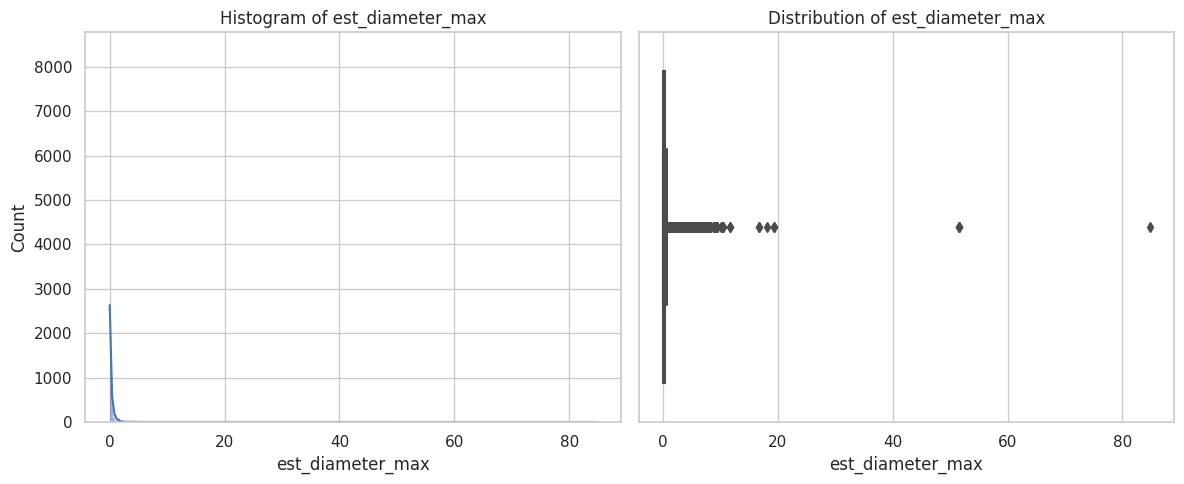

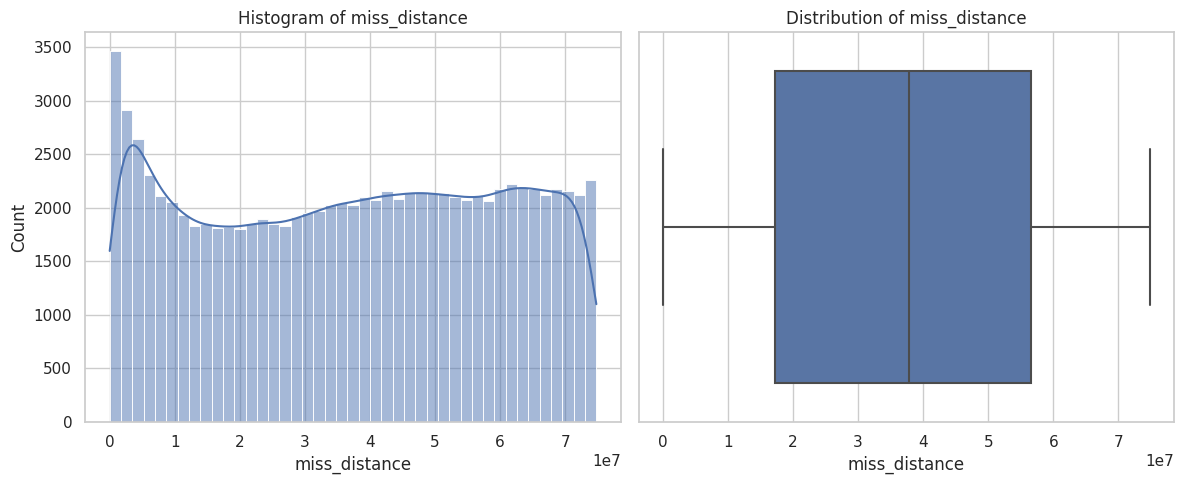

In [41]:
# Create a function to produce our visualizations so we don't repeat this code
def create_distribution_plot(data, column_name):
    # Set the style for the plot (optional)
    sns.set(style="whitegrid")

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot a histogram on the left subplot
    sns.histplot(data=data, x=column_name, kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram of {column_name}')

    # Plot a distribution (box plot) on the right subplot
    sns.boxplot(data=data, x=column_name)
    axes[1].set_title(f'Distribution of {column_name}')

    # Adjust plot layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# What is the distribution of values for sentry_object
sentry_object_values = raw['sentry_object'].value_counts()
print("Sentry object values: ")
print(sentry_object_values)
print()

# How many unique nasa IDs do we have?
unique_ids = raw['id'].value_counts()
print("Unique ID values: ")
print(len(unique_ids))
print()

# How many orbiting bodies do we have?
orbiting_bodies = raw['orbiting_body'].value_counts()
print("List of orbiting bodies")
print(orbiting_bodies)

# Distribution of values for relative_velocity
create_distribution_plot(raw, 'relative_velocity')

# Distribution of values for est_diameter_max
create_distribution_plot(raw, 'est_diameter_max')

# Distribution of values for `miss_distance`
create_distribution_plot(raw, 'miss_distance')

#### Analysis
All instances contain the same values for `orbiting_body` and `sentry_object`. Keeping these features only adds to processing overhead and bloats the data set.

We have 27,423 unique NASA IDs in the data set. A NASA ID is **not** something that would be available "in the field", and would represent data leakage. The same could be said for the name of the object.

We have 2 values representing diameter: `est_diameter_max` and `est_diameter_min`. We don't need two values for this.

In our distribution graph for `relative_velocity` and `est_diameter_max`, we can see a *number* of outliers beyond the 75% IQR mark. We should consider pruning these from the data set to ensure an even distribution of data.

The distribution for `miss_distance` is quite even, and has no obvious outliers beyond IQR boundaries based on the box chart.



#### Tasks
1. I should consider doing some data cleaning and feature engineering. I will end up dropping `id`, `name`, `sentry_object`, and `orbiting_body` from the data set. These do not provide any relevant information and can run the risk of overfitting, and/or can be representative of data leakage.

2. I should also create a new feature, `est_diameter_avg`, which averages the min and max estimated diameter for each instance in the data set. I also think that `est_diameter_min` and `est_diameter_max` should be dropped from the data set after the new feature is engineered.

3. We have some significant outliers on `relative_velocity` and `est_diameter_max` that we should consider pruning from the data set, so as to have a more even distribution of values for the model to consider.

4. I should re-engineer the `hazardous` column to contain an integer representation of whether or not an object is considered hazardous. Having this be an integer (0,1) will assist in performing analysis.

5. After doing the above, an additional round of EDA should be conducted, as well as an exploration of class balance, to ensure that the data is still in an ideal condition to fit to the model.

## Feature Engineering

Feature engineering was covered in the tasks above in each EDA section

## Train Test Split
Given that I will be re-balancing my dataset, I expect to have a final data set somewhere around 16,000 records (8,840 x 2, with some wiggle room for removing outliers and other problematic data). For the example below, we will assume that the final record count is, *in fact*, 16,000. The distribution of values should be fairly equal between hazardous and non-hazardous as well.

Based on these numbers:
*   11,200 records (**70%**) will go to *training* the model
*   3,200 records (**20%**) will go to *testing* the model
*   1,600 records (**10%**) will be set aside as a holdout

All of these records should be selected randomly so as to avoid any bias based on where in the data set the instance occurred. The final numbers will be different based on the final set, but the percentages will be static.

One alternative option could be to select **new** data from the NEO API outside the range that was originally used to populate this data set (dates after 6/15/2022). I am not sure how many events would fall into that category, though, so that may work best as supplementary data to the original data set). The original script used to populate the data is linked in the Data Sources block at the top of this notebook.



## Initial Pipeline
My pipeline will need to have 2 main sections: One to conduct feature engineering, and one to do a model fit.

The feature engineering section will need to accomplish all of the tasks laid out above regarding transforming/adding new features. The model portion of the pipeline will need to fit a classification model to categorize appropriately.

We will also need to, at some point, scrub some values from the `hazardous` column (or hide it from the test set) so that it has something to predict. Otherwise it could use the values already present in the data set and would not have to do any work. I am not entirely sure of the standard practice for doing this yet, but I will learn it as we approach the model fitting step.

## Model Fitting and Evaluation
I believe that the most important features for predicting will be the `miss_distance` and `absolute_magnitude`, given that these should be predictors for whether or not something is hazardous.

I anticipate that the model will recognize the patterns underlying the classification and adapt accordingly. I don't really have the experience to predict a certain % of success, but I do expect it to perform well.

I plan on evaluating the efficacy of the model by using a confusion matrix so we can see the precision and accuracy of the model's output. I can also evaluate the arithmatic and arithmetic means so we can explore the results from many perspectives.